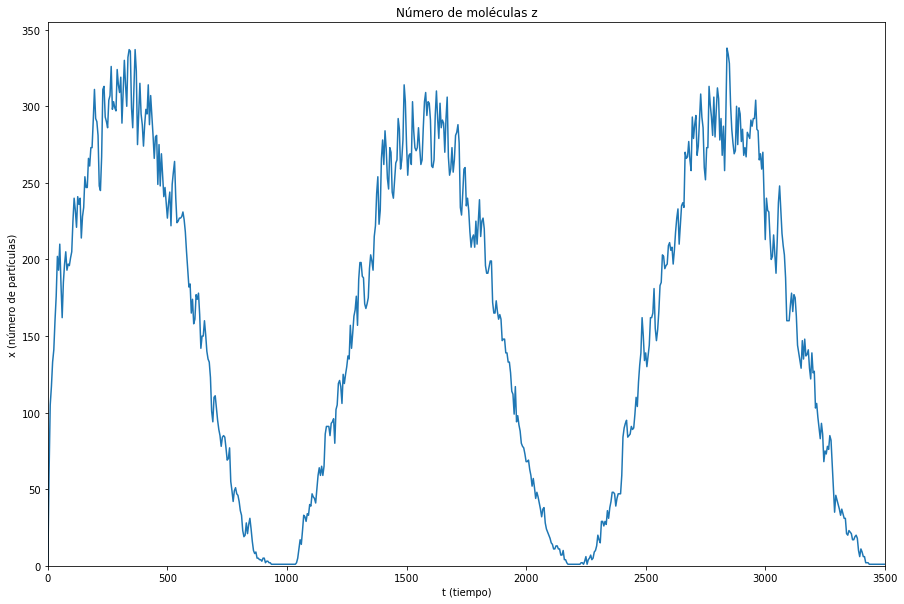

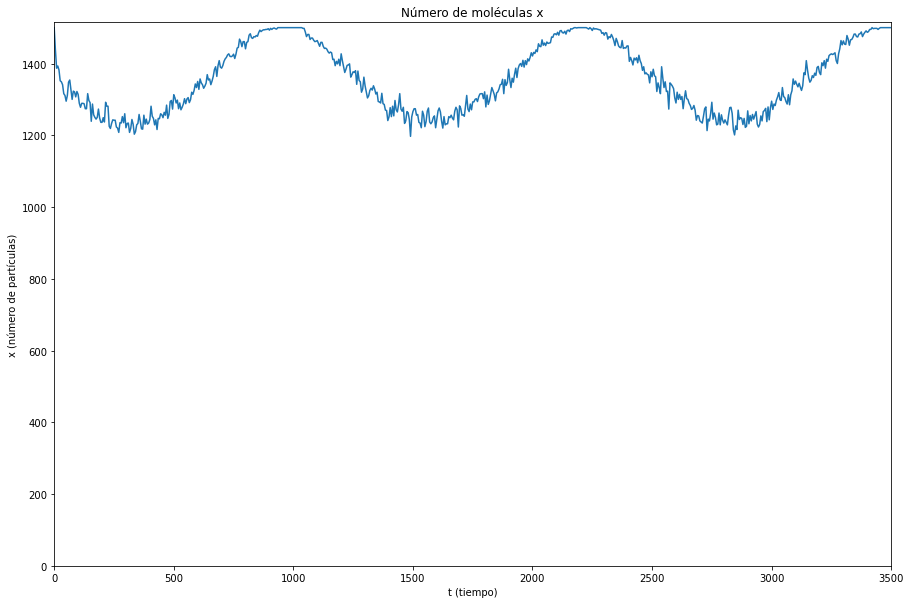

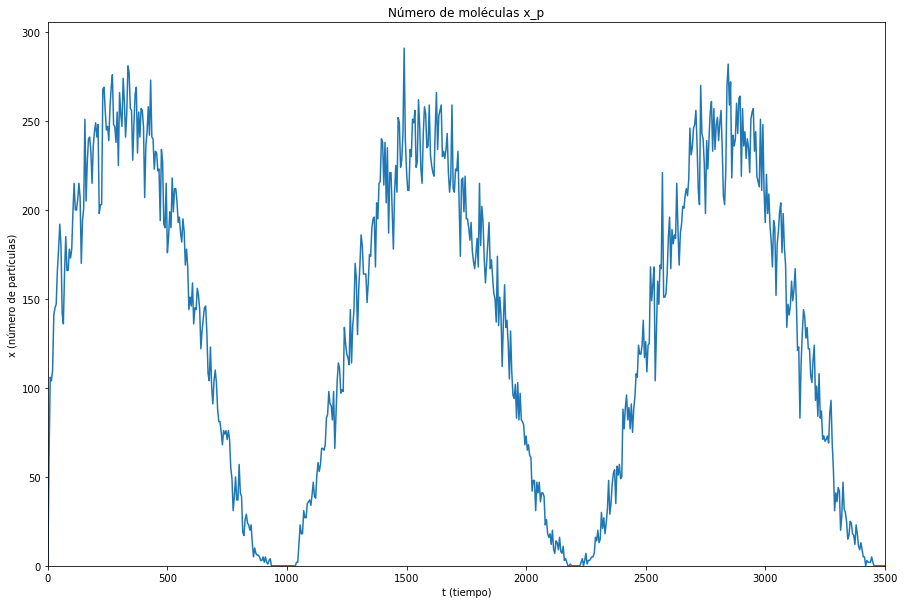

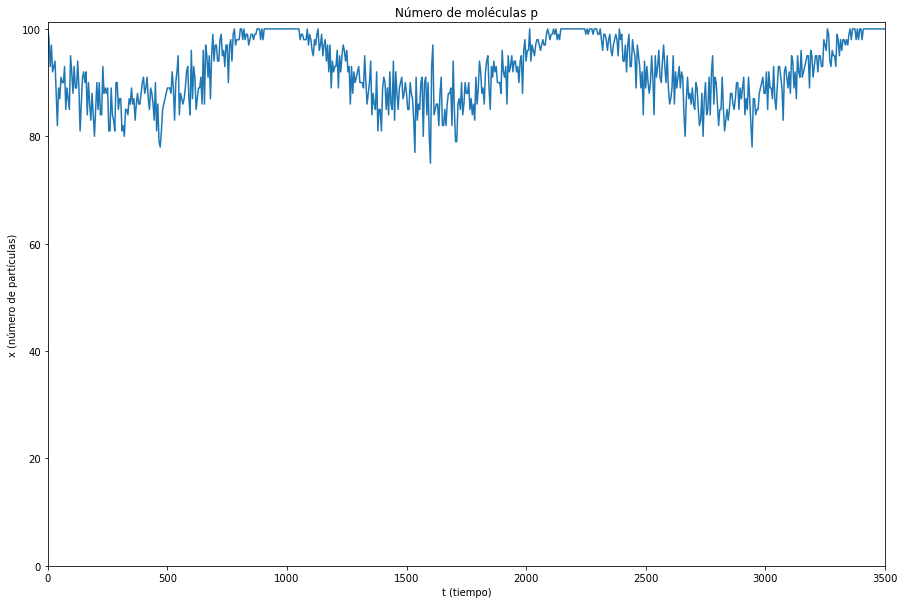

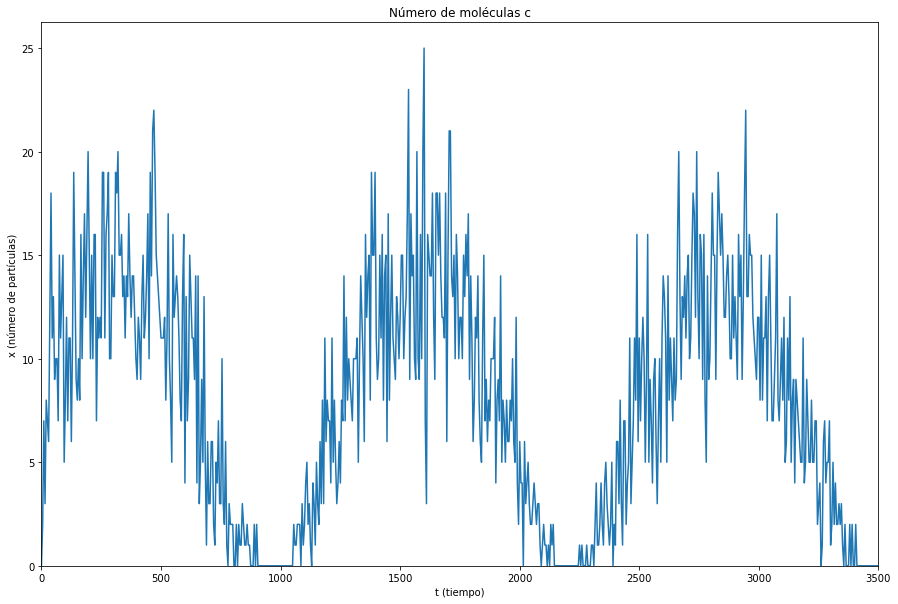

In [ ]:
'Algoritmo de Guillespie' 'fosfoliracion caso 1'

#En este programa se implementa el agoritmo de Gillespie para reacciones quimicas
#comunes y convencionales.

# se importan las librerias que seran usadas
import numpy as np
import math 
import random as rnd
import matplotlib.pyplot as plt
from numba import cuda

#para implementar el algoritmo son necesarias algunas cantidades y definir algunos parametros
#condiciones iniciales de las variables involucradas y el tiempo

def z(t):
    return 0.01*(1+ math.sin(0.005*t))

t0=0 #tiempo inicial
tf= 3500 # tiempo final
t1=5
Omega=1500 #tamano del sistema
x=[0, Omega, 0, Omega, 100, 0] #vector de condiciones iniciales [X0,Y0,Z0]
h= 1 #numero de veces para realizar la misma simulacion
n= len(x) #numero de especies quimicas involucradas

#parametros
k1=[50,50,10]  #vector de k+
k2=[0, 0, 10]  #vector de k-

#matrices de coeficientes estequiometricos
alpha= [[1,1,0,0,0,0],
        [0,0,1,1,0,0],
        [0,0,1,0,1,0],
        [0,0,0,0,0,0]]

beta= [[1,0,1,0,0,0],
       [0,1,0,1,0,0],
       [0,0,0,0,0,1],
       [1,0,0,0,0,0]]

#contruimos la matriz estequiometrica 'evitar editar a partir de esta linea'
S= np.subtract( beta,alpha)
S=S.T
S= np.append(S, -S, axis = 1)

# miscelanea de funciones usadas
def dist_exp(a):# funcion para calcular tau 
    r = rnd.random()
    return -(1./(a))*math.log(r)
    
def numero(S1,a): # funcion que devuelve mu
    l1=0
    l2= S1[0]/a
    l3=0
    r=np.random.rand()
    while l3<1:
        if r<=l2:
            l3+= 1
            return l1
        else:
            l1+= 1
            l2+= S1[l1]/a
 
# la funcion que esta a continuacion nos permite realizar  el proceso estocastico hasta que haya 
#pasado T tiempo para un determinado tamano del sistema.


def ev(x,j): #x=condicion inicial, p= numero de pasos, j=tamano del sistema
    t = np.arange(0,tf+t1,t1)
    l3=0
    Z=np.zeros([n,len(t)])
    Y = x
    Z[:,0] = x[:]
    l6=1
    while l6<len(t) or l3<tf:
        if l3<(l6)*t1:
            ni1 = [k1[0]*Y[0]*Y[1]/(j**2), k1[1]*Y[2]*Y[3]/(j**2), k1[2]*Y[2]*Y[4]/(j**2), z(l3),0 , 0, k2[2]*Y[5]/j,0.1*Y[0]/j] #vector de propension
            a=sum(ni1)
            tau = dist_exp(a)/j
            mu = numero(ni1,a)
            Y[:] +=  S[:,mu]
            l3+= tau
        else:
            Z[:,l6]=Y[:]
            l6+= 1
    return t ,  Z

#con la funcion que ya hemos programado, podemos repetirla algun numero determinado de veces,
# para ello claculamos la funcion anterior algun numero de veces y la graficamos 

nom=['Número de moléculas z', 'Número de moléculas x', 'Número de moléculas x_p', 
    'Número de moléculas y', 'Número de moléculas p', 'Número de moléculas c' ]

def varios1(x,j,q): #p= pasos  j= tamano del sistema, 
   # q= numero de veces que se realiza la misma simulacion 
    l1=0
    l2=len(x)
    while l1<q:
        T0, l3 =ev(x,j)
        for i in range(l2):
          if i!=3: 
            plt.figure(i,figsize=(15,10))
            plt.plot(T0,l3[i])
            plt.xlabel("t (tiempo)")
            plt.ylabel("x (número de partículas)")
            plt.title(nom[i])
            plt.xlim(0, tf)
            plt.ylim(-0.0005)
        l1=l1+1
    #plt.legend()
    plt.show()

   
#realizar las graficas de las variables
varios1(x,Omega,h)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


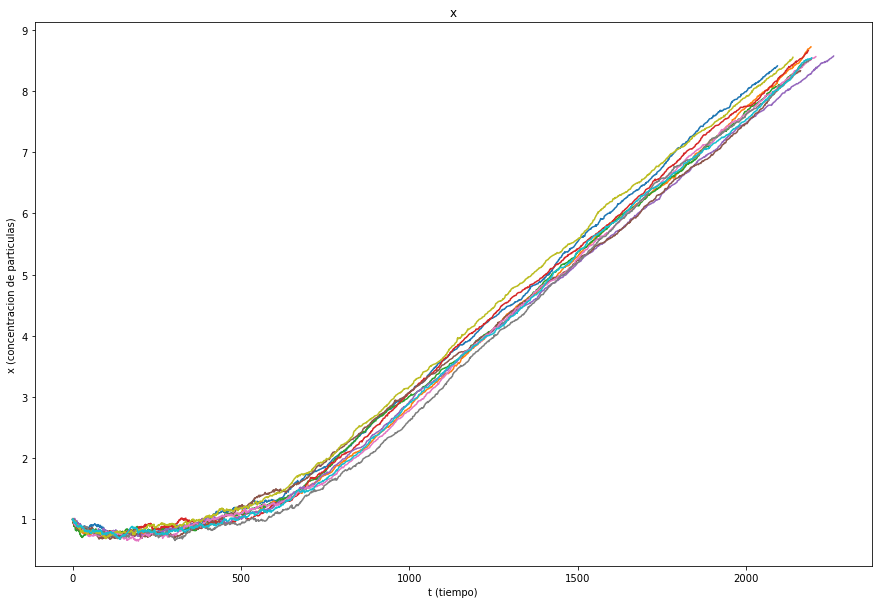

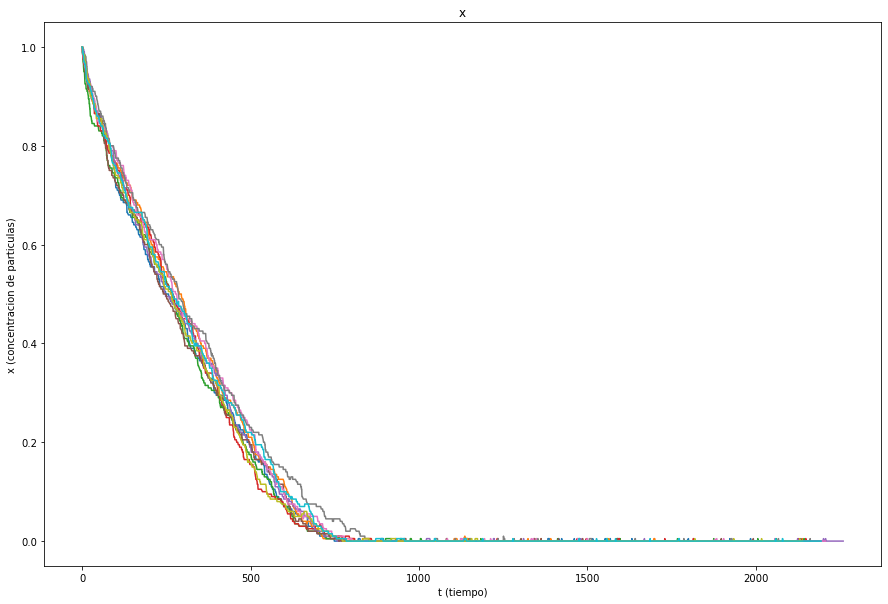

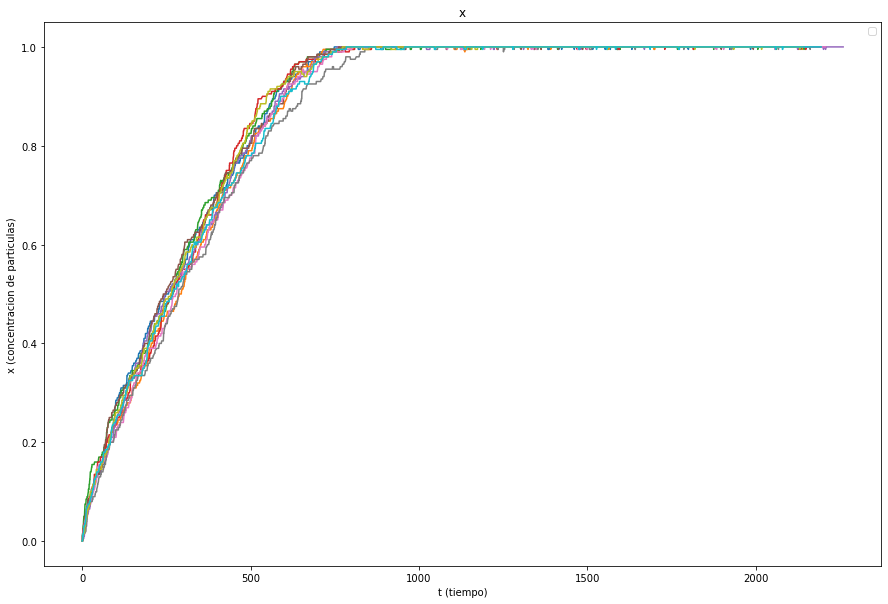

In [ ]:
'Algoritmo de Guillespie' 'Metodo directo'

#En este programa se implementa el agoritmo de Gillespie para reacciones quimicas comunes y convencionales.

# se importan las librerias que seran usadas
import numpy as np
import math 
import random as rnd
import matplotlib.pyplot as plt

#para implementar el algoritmo son necesarias algunas cantidades y definir algunos parametros
#condiciones iniciales de las variables involucradas y el tiempo
t0=0.0 #tiempo inicial
tf= 500 # tiempo final
Omega=200 #tamano del sistema
x=[Omega, Omega, 0] #vector de condiciones iniciales [X0,Y0,Z0]
N=3  #coeficiente de Hill
P=2500 #numero de pasos

#parametros
k1=[1,1]  #vector de k+
k2=[0.01,0.01]  #vector de k-

#matrices de coeficientes estequiometricos
alpha= [[0,0,0],
        [N,1,0]]

beta= [[1,0,0],
       [0,0,1]]

#contruimos la matriz estequiometrica 'evitar editar a partir de esta linea'
S= np.subtract( beta,alpha)
S=S.T
S= np.append(S, -S, axis = 1)

# miscelanea de funciones usadas

def fac(n): #x!
    if n<0:
        return 0
    else:
        l1=0
        l2=1
        while l1 < n:
          l1=l1+1
          l2=l1*l2
        return l2

def prod(x, n): # x!/(x-n)!
    l2=x-n
    if n==0:
        return 1
    if l2==0 or l2==1:
        return fac(x)
    else:
        xprod= l2+1
        if n!=0 and l2>0:
            for i in range(1,n):
                xprod= xprod * (l2+1+i)
            return xprod
        elif l2<0:
             return 0
        else:
            return 1

def elevar(x,n): #x**n
    if n==0:
        return 1
    else:
        return x**n

# elementos para realizar el proceso estocastico

def tazas(x,vector,k,Omega):  # taza de reaccion de una variable
    l1=len(x)
    l2=0
    l3=[]
    while l2<l1:
        l4=(prod(x[l2],vector[l2]))/(elevar(Omega,vector[l2]))
        l2=l2+1
        l3.append(l4)
    l4=1
    l2=0
    while l2<l1:
        l4=l4*l3[l2]
        l2=l2+1
    return k*l4

def ni(x,A,B,k1,k2,Omega): #construimos el vector de propension del sistema
    l1=len(k1)
    l2=[]
    l3=[]
    l4=0
    while l4<l1:
        y1=tazas(x,A[l4],k1[l4],Omega)
        l2.append(y1)
        y2=tazas(x,B[l4],k2[l4],Omega)
        l3.append(y2)
        l4=l4+1
    return l2+l3

def dist_exp(S1):# funcion para calcular tau 
    a=sum(S1)
    r = rnd.random()
    return -(1./a)*math.log(r)
    
def numero(S1): # funcion que devuelve mu
    a=sum(S1)
    l1=0
    l2= S1[0]/a
    l3=0
    r=np.random.rand()
    while l1<len(S1):
        if l3==0:
            if r<=l2:
                if S1[l1]!=0:
                    l3=l3+1
                    return (l1)
            else:
               l1=l1+1
               l2= l2 + S1[l1]/a
 
# la funcion que esta a continuacion nos permite realizar  el proceso estocastico hasta que hayan ocurrido p 
#reacciones continuas para un determinado tamano del sistema.

def ev(x,p,j): #x=condicion inicial, p= numero de pasos, j=tamano del sistema
    l1=len(x)
    Y = np.zeros([l1,p+1])
    t = np.zeros(p+1)
    for j1 in range(l1):
            Y[j1][0] = x[j1]
    t[0]=t0
    for i in range(p):
        ni1 = ni(x,alpha,beta,k1,k2,j) #vector de propension
        tau = dist_exp(ni1)
        mu = numero(ni1)
        t[i+1] = t[i] + tau
        l2=[]
        for j1 in range(l1):
            Y[j1][i+1] = Y[j1][i] + S[j1][mu]
            l2.append(Y[j1][i+1])
        x=l2
    return t ,  Y/j

#con la funcion que ya hemos programado, podemos repetirla algun numero determinado de veces,
# para ello claculamos la funcion anterior algun numero de veces y la graficamos 

def varios(x,p,j,q): #p= pasos  j= tamano del sistema, q= numero de veces que se realiza la misma simulacion 
    l1=0
    l2=len(x)
    l3=np.zeros(l2)
    while l1<q:
        T0, l3 =ev(x,p,j)
        for i in range(l2):
            plt.figure(i, figsize=(15,10))
            plt.plot(T0,l3[i])
            plt.xlabel("t (tiempo)")
            plt.ylabel("x (concentracion de particulas)")
            plt.title("x" )
        l1=l1+1
    plt.legend()
    # Guardar grafico como imagen PNG.
    plt.savefig("hill.png")
    plt.show()

# como alternativa podemos realizar las simulaciones en un intervalo de tamano
# omega={a,b}
def val(x,p,a,b):
    plt.figure(3)
    for j in range(a,b+1):
        T0, Y01, Y1 =ev(x,p,j)
        plt.plot(T0,Y01)
        plt.plot(T0,Y1)
    plt.xlabel("t")
    plt.ylabel("x (concentracion de particulas)")
    plt.title("x")
    plt.show()

#realizar las graficas de las variables
varios(x,P,Omega,10)